# Making Prediction with fbprophet (Facebook Prophet) Library

- Performing time-series analysis and crime occurence prediction with the Facebook Prophet Library

In [1]:
#%matplotlib notebook

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark import SparkContext
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import fbprophet

In [3]:
sqlContext = SQLContext(sc)

Loading the dataset

In [4]:
dataPath ='../ts-test/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv'

crimeDataSchema = StructType([StructField("IncidntNum", LongType(), True),
                              StructField("Category", StringType(), True),
                              StructField("Descript", StringType(), True),
                              StructField("DayOfWeek", StringType(), True),
                              StructField("Date", StringType(), True),
                              StructField("Time", StringType(), True),
                              StructField("PdDistrict", StringType(), True),
                              StructField("Resolution", StringType(), True),
                              StructField("Address", StringType(), True),
                              StructField("X", DoubleType(), True),
                              StructField("Y", DoubleType(), True),
                              StructField("Location", StringType(), True),
                              StructField("PdId", LongType(), True)])

crimeDF = (sqlContext.read
           .format('csv')
           .option('delimiter', ',')
           .option('header', 'true')
           .load(dataPath, schema=crimeDataSchema))

In [5]:
from pyspark.sql.functions import udf, unix_timestamp, to_timestamp
import datetime


def parseDate(dateStr):
    return unix_timestamp(dateStr, 'MM/dd/yyyy').cast('timestamp')

crimeDF_date = (crimeDF.withColumn("Date_tmp", unix_timestamp(crimeDF.Date, 'MM/dd/yyyy').cast('timestamp')) #.withColumn("Date_tmp", udf(parseDate, TimestampType())(crimeDF.Date))
         .drop("Date")
         .withColumnRenamed("Date_tmp", "Date"))

In [6]:
crime_date_count = crimeDF_date.groupBy("Date", "Category").count().select("Date","Category", "Count").orderBy("Date")

In [7]:
def intCount(c):
    return float(c)

crime_date_count = (crime_date_count.withColumn("Count_t", udf(intCount, DoubleType())(crime_date_count.Count))
                                   .drop("Count")
                                   .withColumnRenamed("Count_t", "Count")
                                   .cache())

The dataframe was reconstructed to have "Date" in timestamp format and "Count" in Double type

In [8]:
crime_date_count.show()

+-------------------+--------------------+-----+
|               Date|            Category|Count|
+-------------------+--------------------+-----+
|2003-01-01 00:00:00|             ROBBERY| 10.0|
|2003-01-01 00:00:00|SEX OFFENSES, NON...|  1.0|
|2003-01-01 00:00:00|             ASSAULT| 96.0|
|2003-01-01 00:00:00|               FRAUD| 23.0|
|2003-01-01 00:00:00|FORGERY/COUNTERFE...| 16.0|
|2003-01-01 00:00:00|        PROSTITUTION|  6.0|
|2003-01-01 00:00:00|SEX OFFENSES, FOR...| 13.0|
|2003-01-01 00:00:00|        NON-CRIMINAL| 65.0|
|2003-01-01 00:00:00|           EXTORTION|  1.0|
|2003-01-01 00:00:00|           VANDALISM| 28.0|
|2003-01-01 00:00:00|               ARSON|  1.0|
|2003-01-01 00:00:00|             RUNAWAY|  1.0|
|2003-01-01 00:00:00|       LARCENY/THEFT| 72.0|
|2003-01-01 00:00:00|  DISORDERLY CONDUCT|  3.0|
|2003-01-01 00:00:00|      OTHER OFFENSES| 91.0|
|2003-01-01 00:00:00|           LOITERING|  1.0|
|2003-01-01 00:00:00|      SUSPICIOUS OCC| 35.0|
|2003-01-01 00:00:00

In [9]:
list_of_cats = [r.Category for r in crime_date_count.select("Category").distinct().collect()]

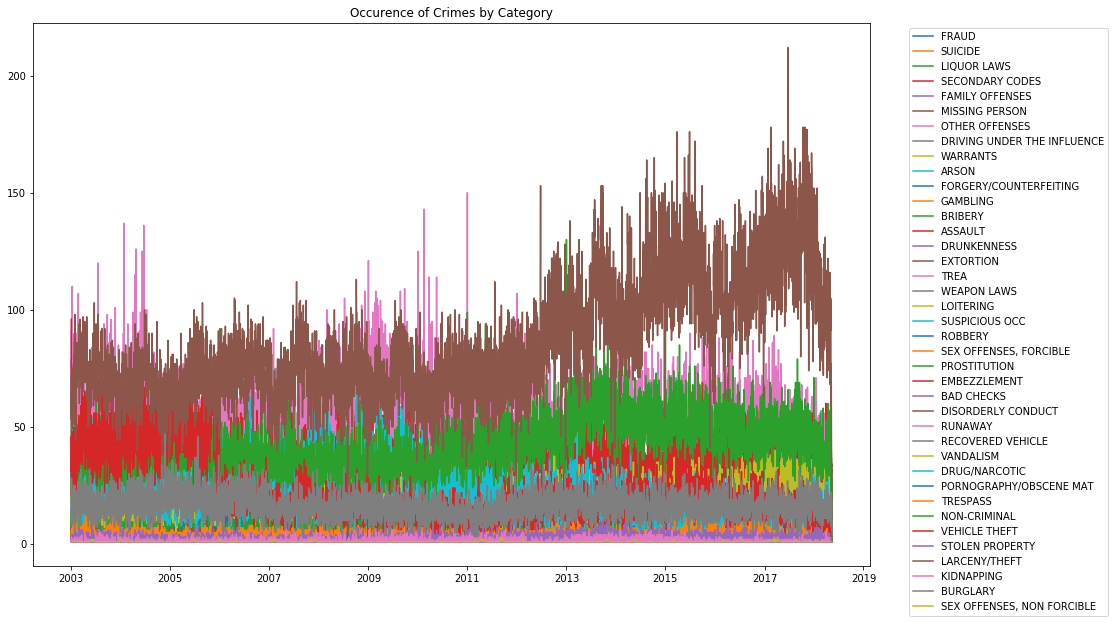

In [10]:
plt.figure(figsize=[15,10])

plt.title('Occurence of Crimes by Category')

for cat in list_of_cats:
    data = crime_date_count.where(crime_date_count["Category"] == cat).select("Date", "Count")
    dates_c = [d.Date for d in data.select("Date").collect()]
    counts_c = [r.Count for r in data.select("Count").collect()]
    plt.plot(dates_c, counts_c, label=cat)

plt.legend(loc='upper left',bbox_to_anchor=(1.04,1))
plt.show()

In [11]:
dates = crime_date_count.select("Date").collect()
dates = [d.Date for d in dates]

In [12]:
minDate = dates[0]
maxDate = dates[len(dates) - 1]

Divide the data to one from the earliest date to 2018/3/31 and one from 2018/4/1 to 2018/4/30
- The first set is used to fit the model
- The second set is used to check the prediction result

In [13]:
crime_date_count_sample = crime_date_count.where(crime_date_count.Date.between(minDate, datetime.datetime(2017, 5, 15, 0, 0))).cache()
crime_date_count_sample_future = crime_date_count.where(crime_date_count.Date.between(datetime.datetime(2017, 5, 16, 0, 0), maxDate)).cache()


In [14]:
crime_date_count_sample.show()

+-------------------+--------------------+-----+
|               Date|            Category|Count|
+-------------------+--------------------+-----+
|2003-01-01 00:00:00|             ROBBERY| 10.0|
|2003-01-01 00:00:00|SEX OFFENSES, NON...|  1.0|
|2003-01-01 00:00:00|             ASSAULT| 96.0|
|2003-01-01 00:00:00|               FRAUD| 23.0|
|2003-01-01 00:00:00|FORGERY/COUNTERFE...| 16.0|
|2003-01-01 00:00:00|        PROSTITUTION|  6.0|
|2003-01-01 00:00:00|SEX OFFENSES, FOR...| 13.0|
|2003-01-01 00:00:00|        NON-CRIMINAL| 65.0|
|2003-01-01 00:00:00|           EXTORTION|  1.0|
|2003-01-01 00:00:00|           VANDALISM| 28.0|
|2003-01-01 00:00:00|               ARSON|  1.0|
|2003-01-01 00:00:00|             RUNAWAY|  1.0|
|2003-01-01 00:00:00|       LARCENY/THEFT| 72.0|
|2003-01-01 00:00:00|  DISORDERLY CONDUCT|  3.0|
|2003-01-01 00:00:00|      OTHER OFFENSES| 91.0|
|2003-01-01 00:00:00|           LOITERING|  1.0|
|2003-01-01 00:00:00|      SUSPICIOUS OCC| 35.0|
|2003-01-01 00:00:00

In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)  #Setting the logging level to remove unwanted warning in plots

### Prediction by Category
- Plot the predicted values and the actual value from the dataset for 1-year period predicted (2017/5/16 ~ 2018/5/15)

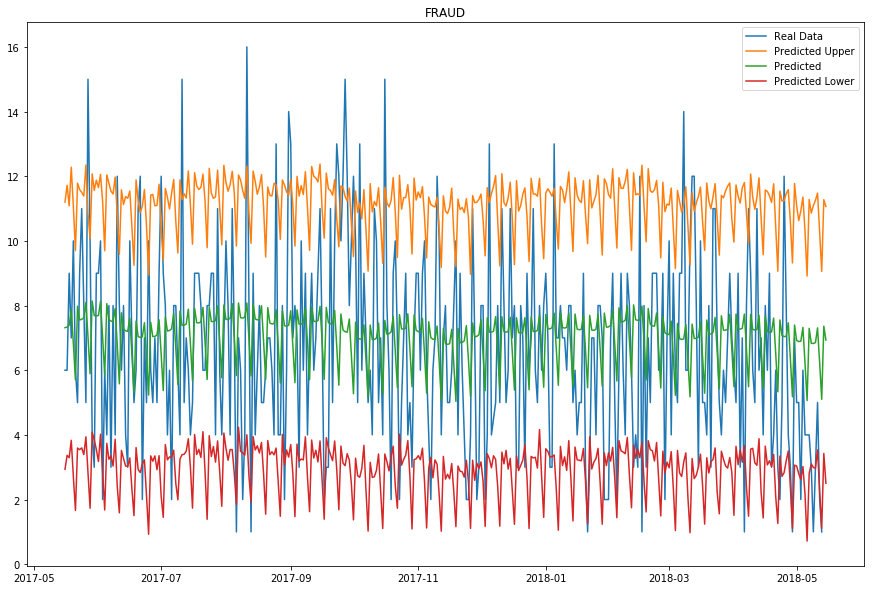

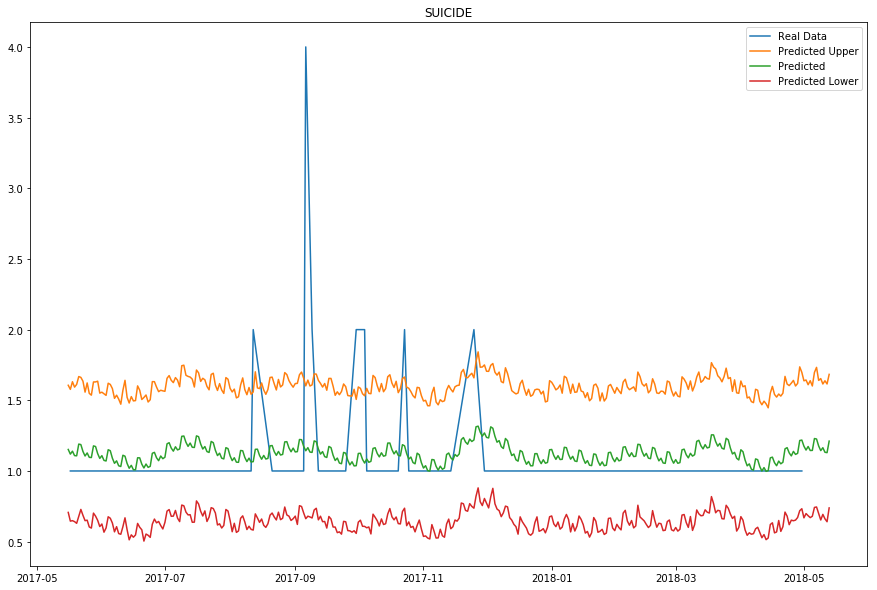

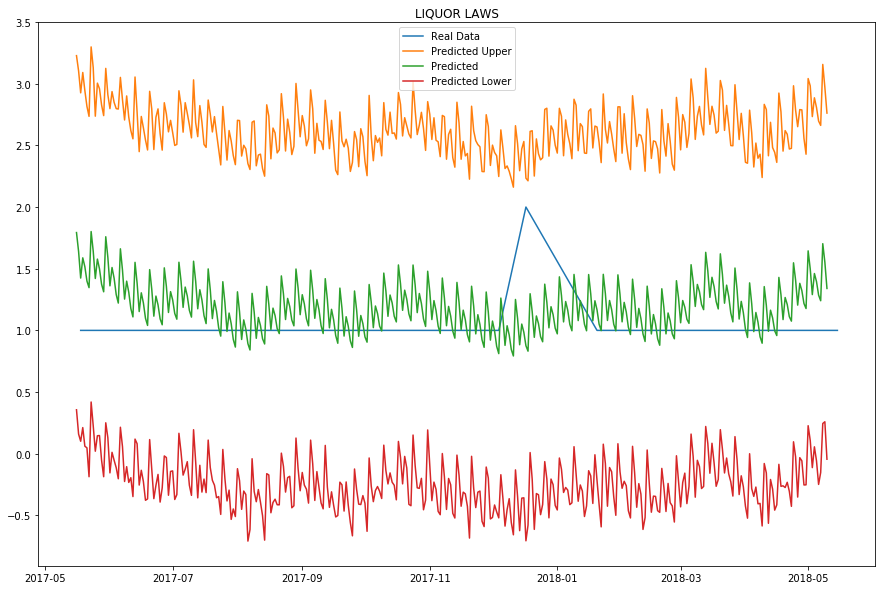

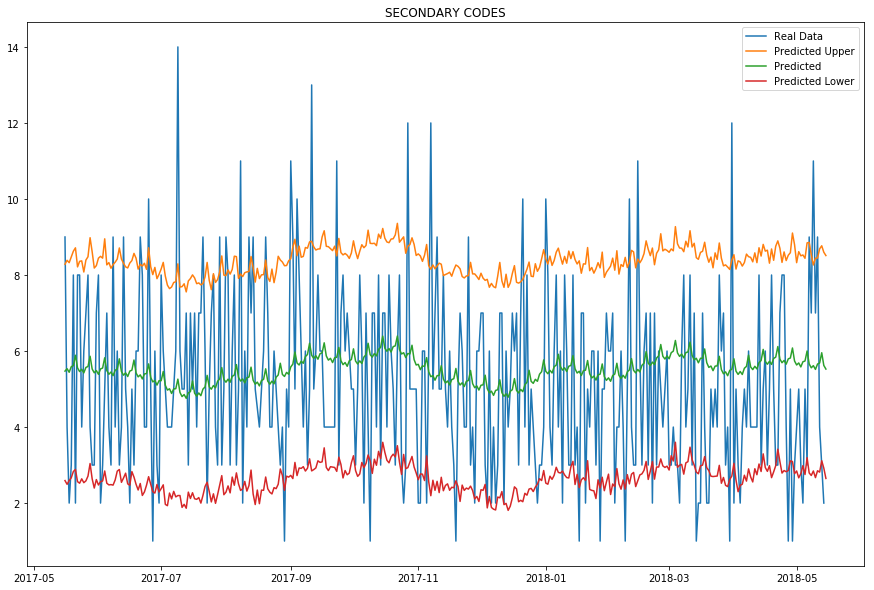

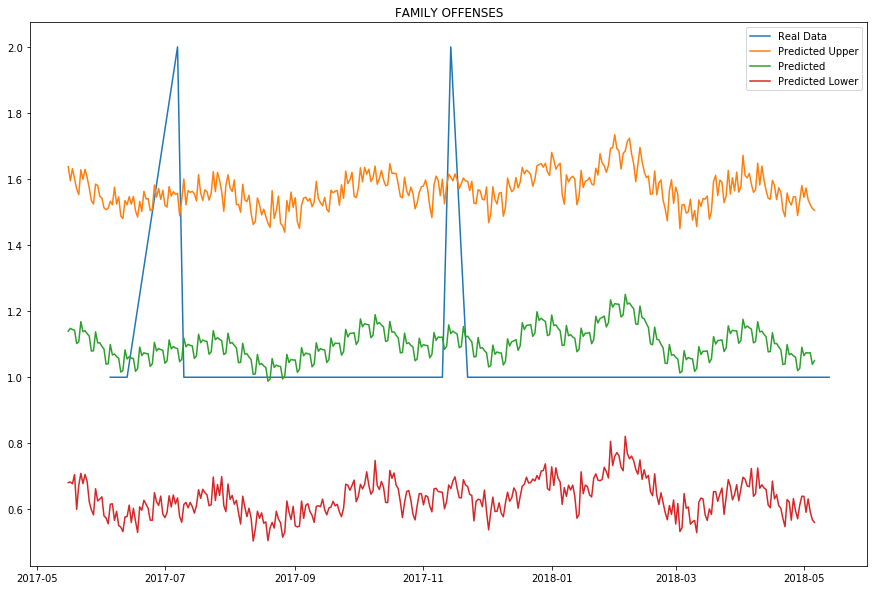

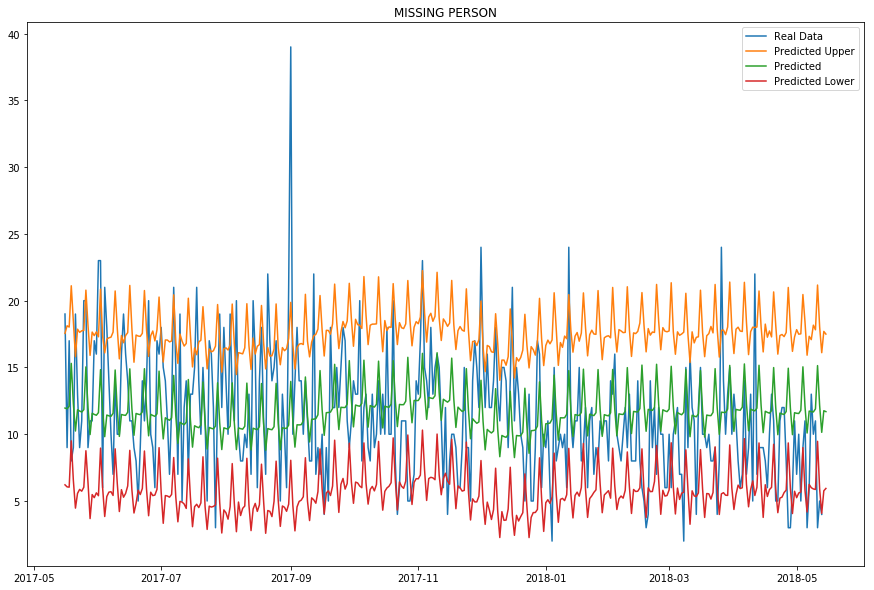

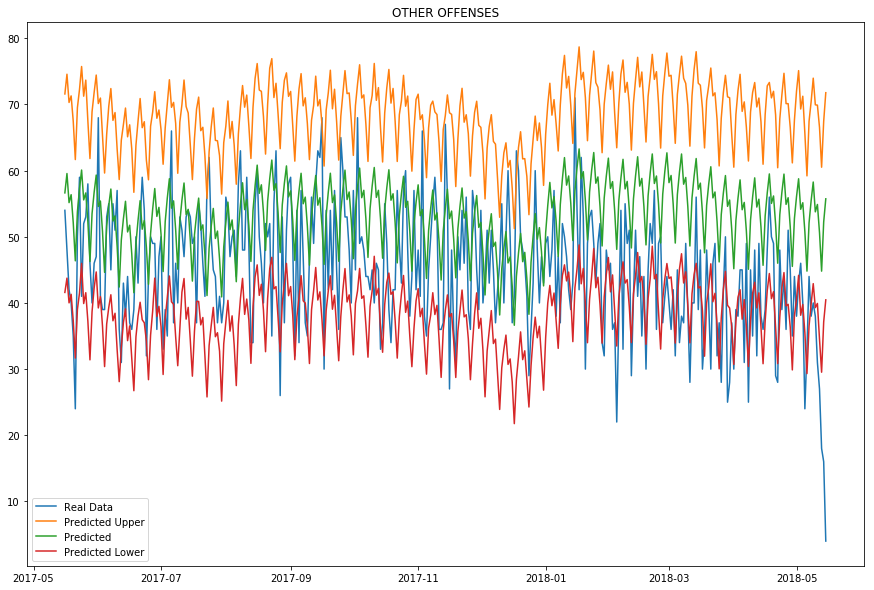

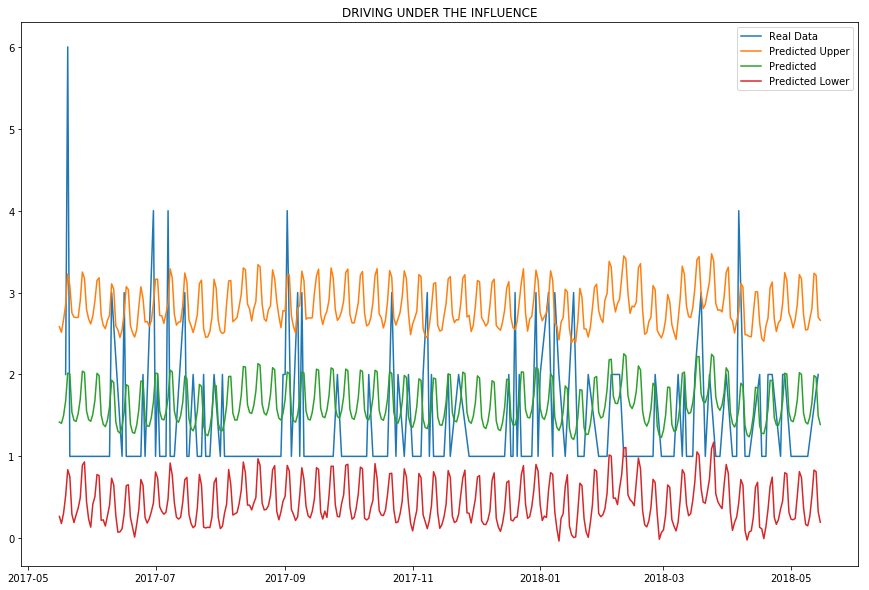

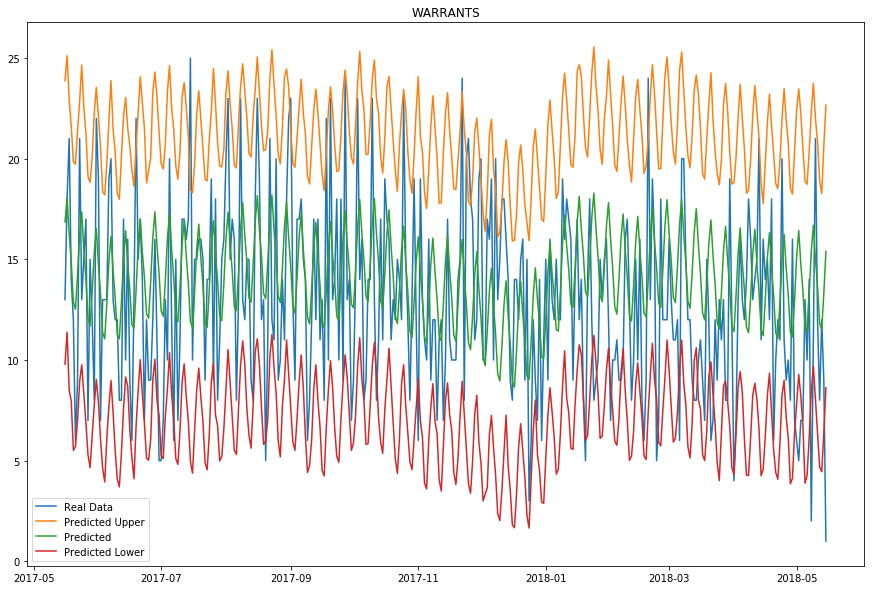

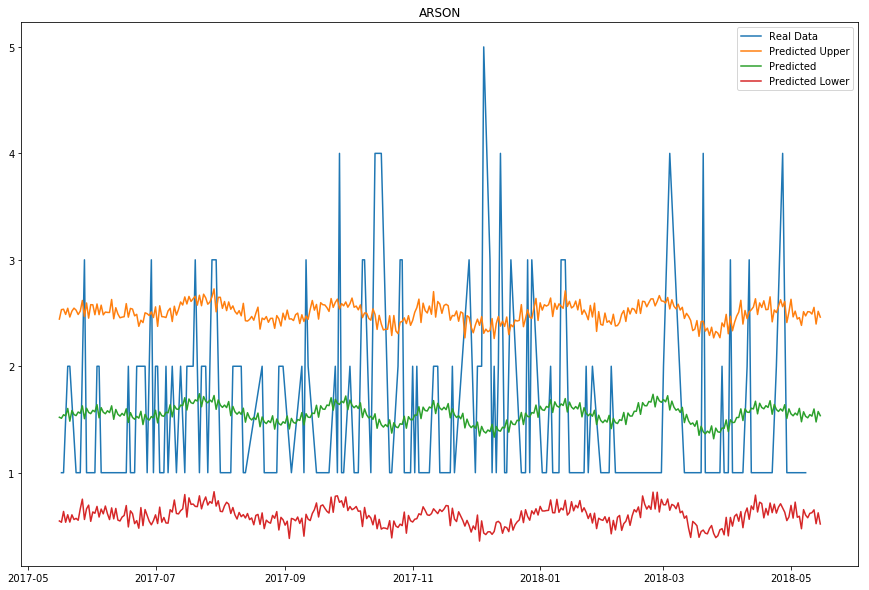

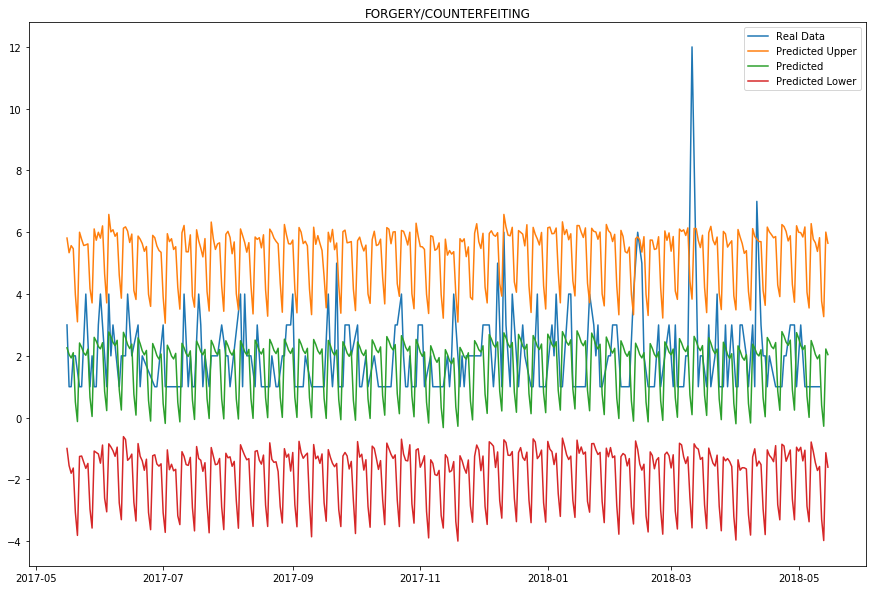

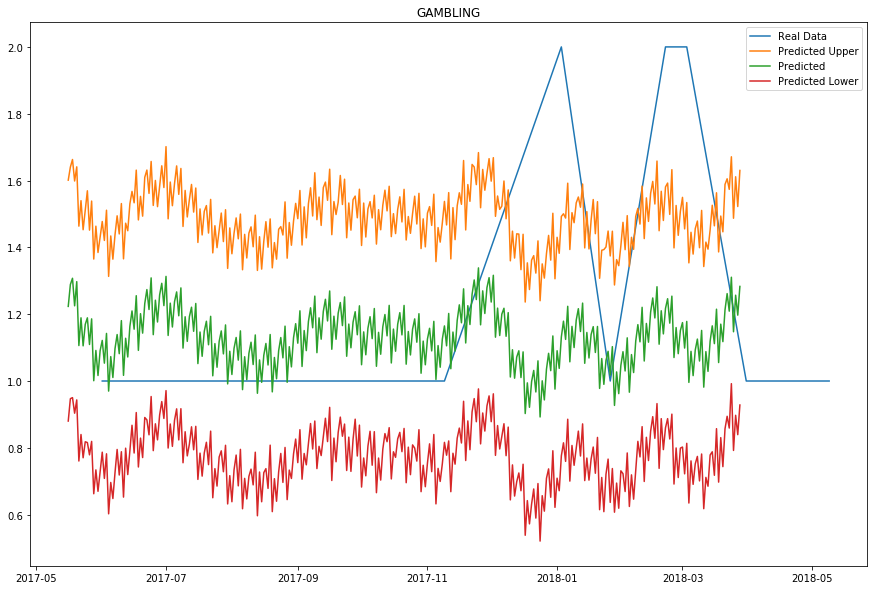

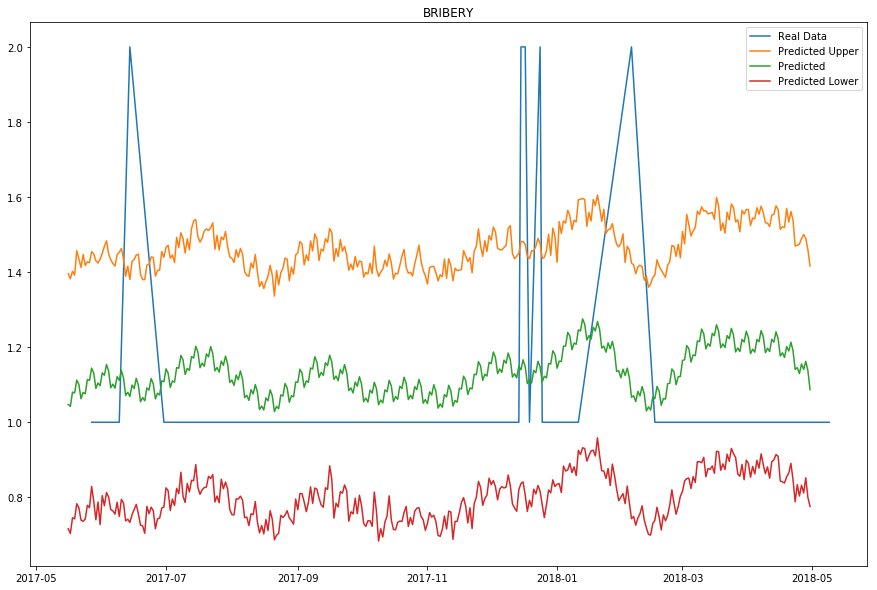

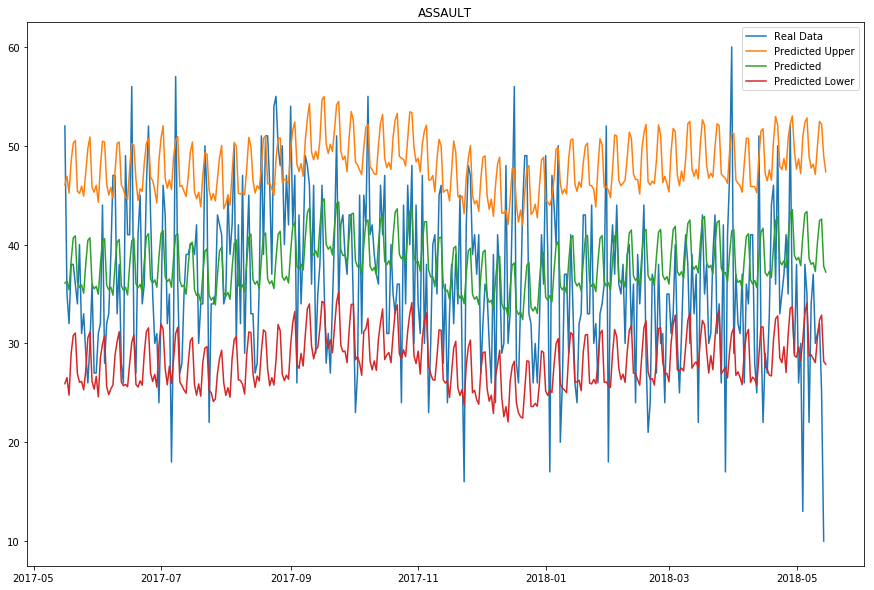

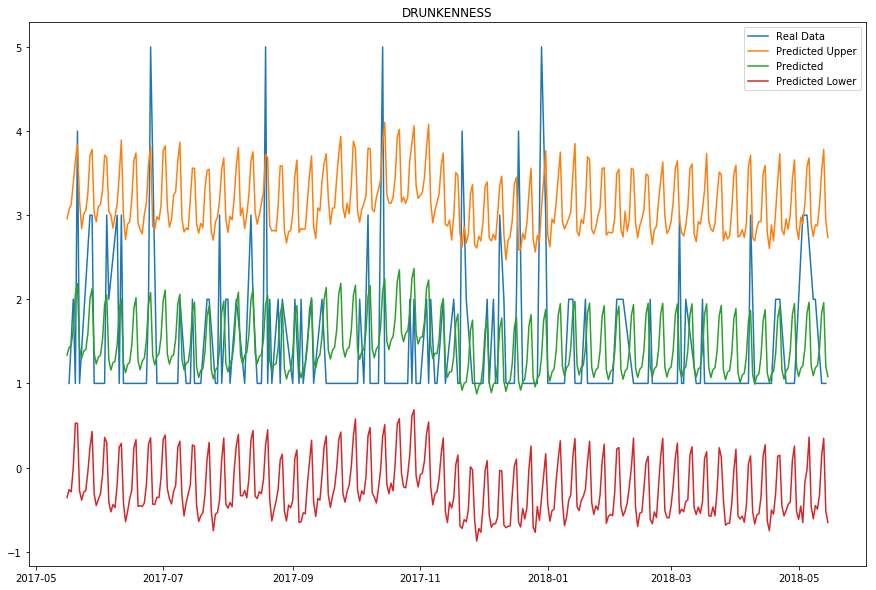

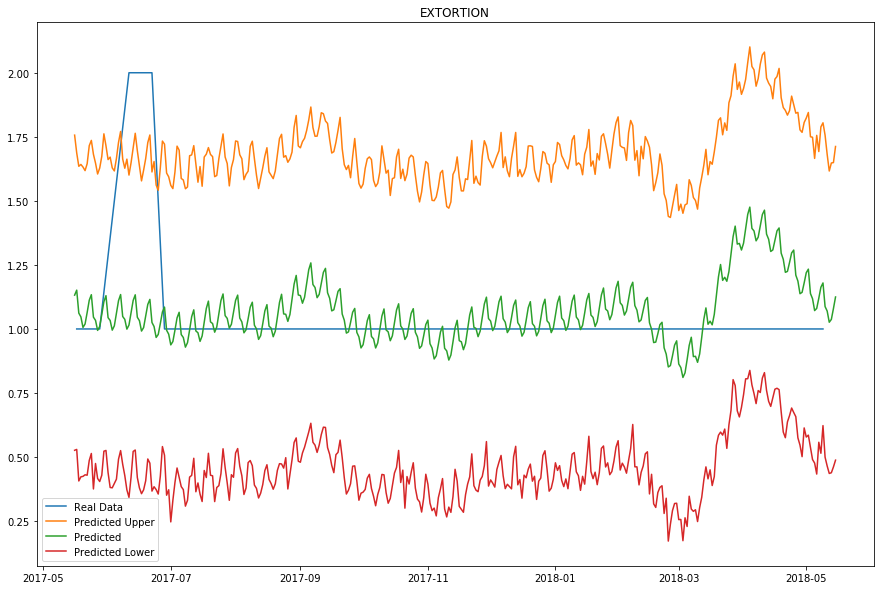

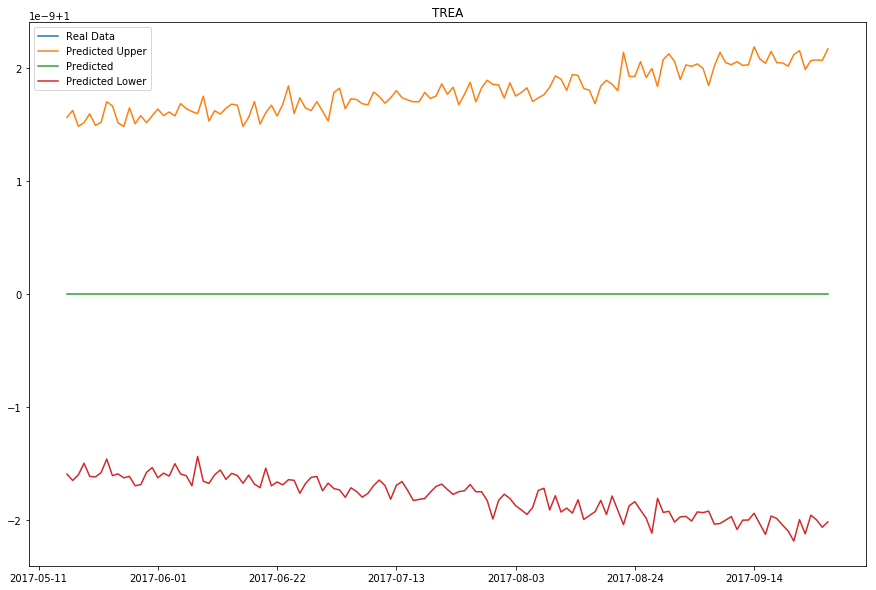

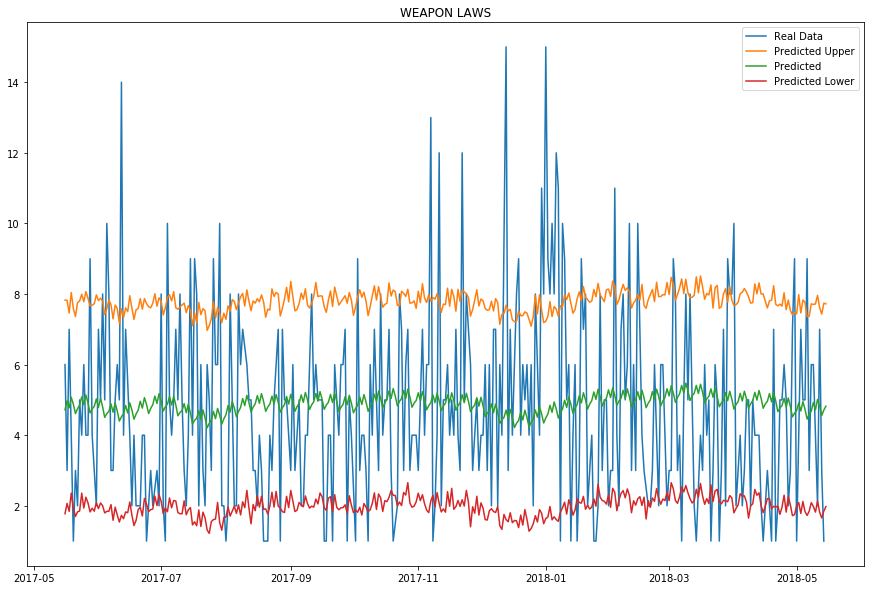

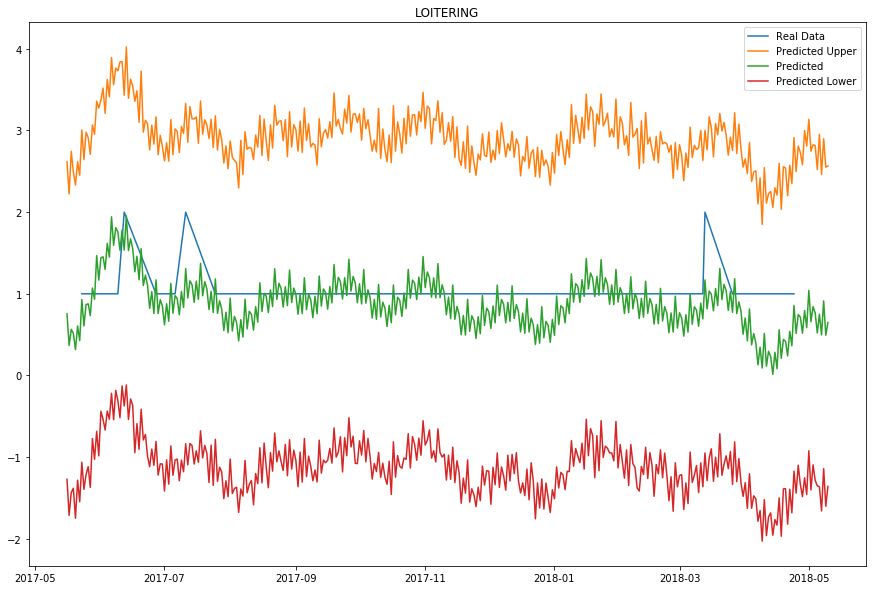

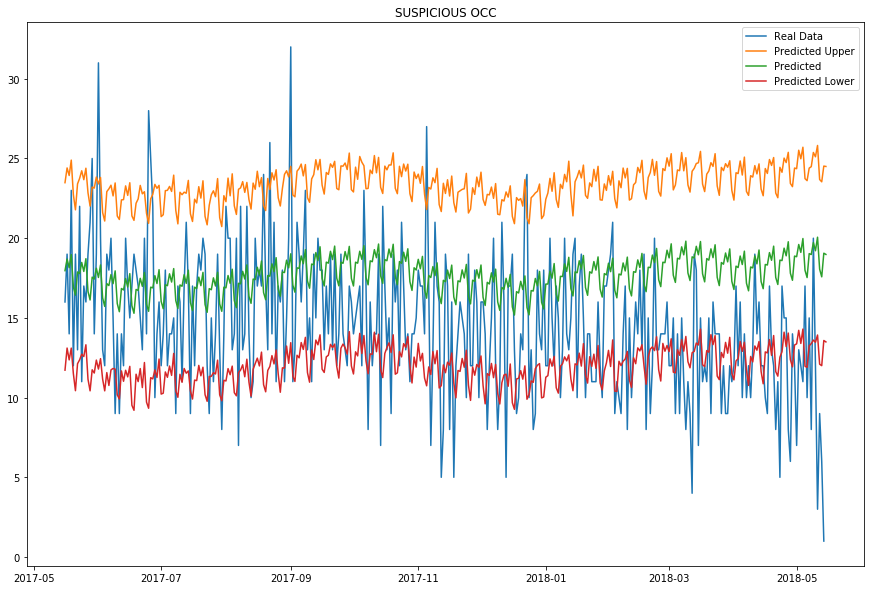

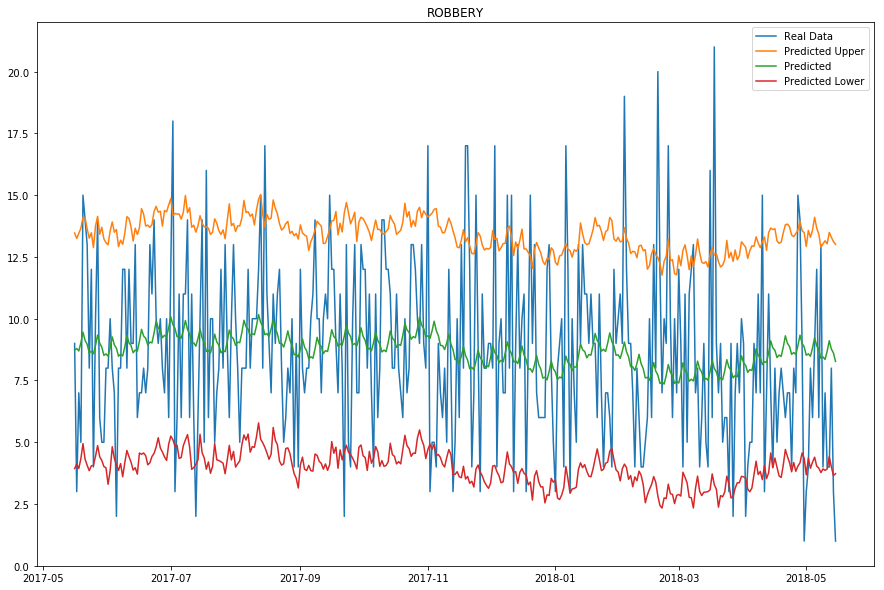

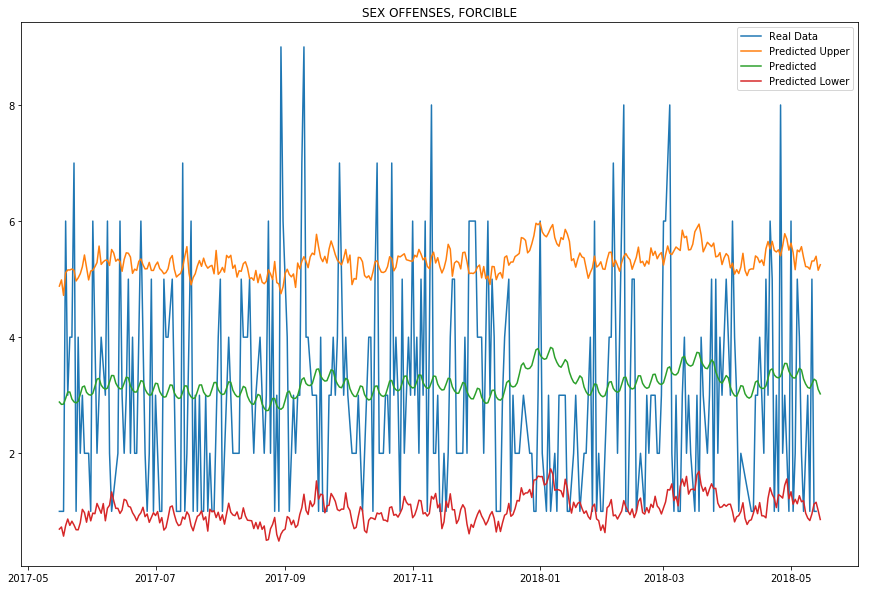

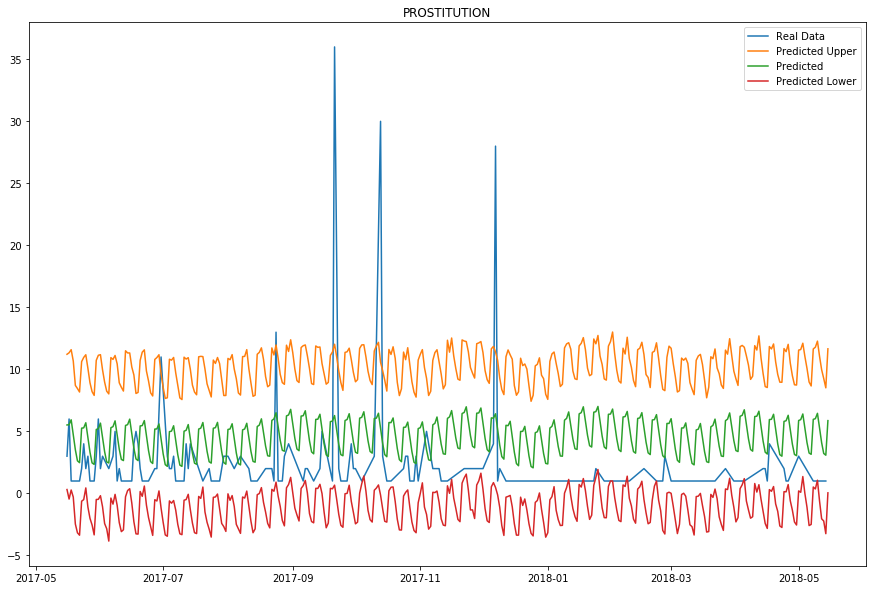

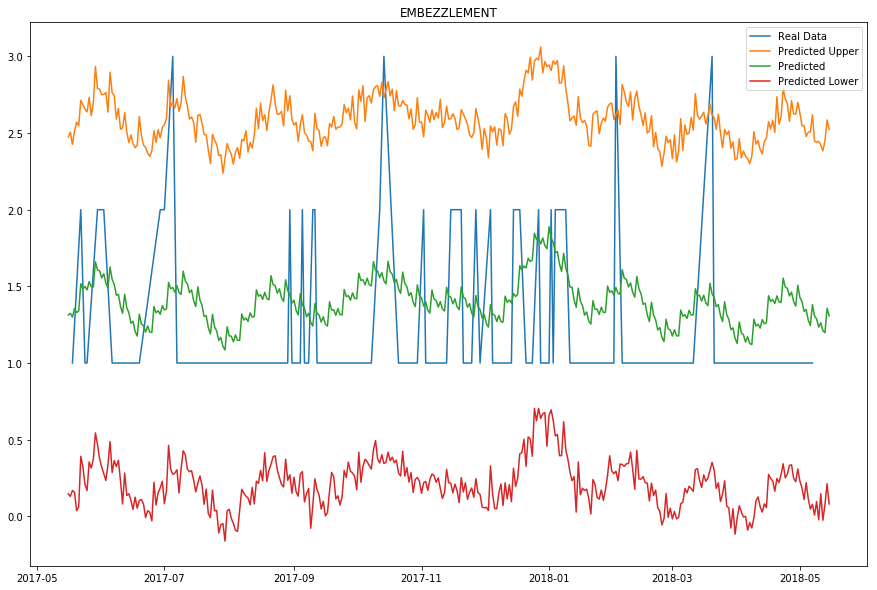

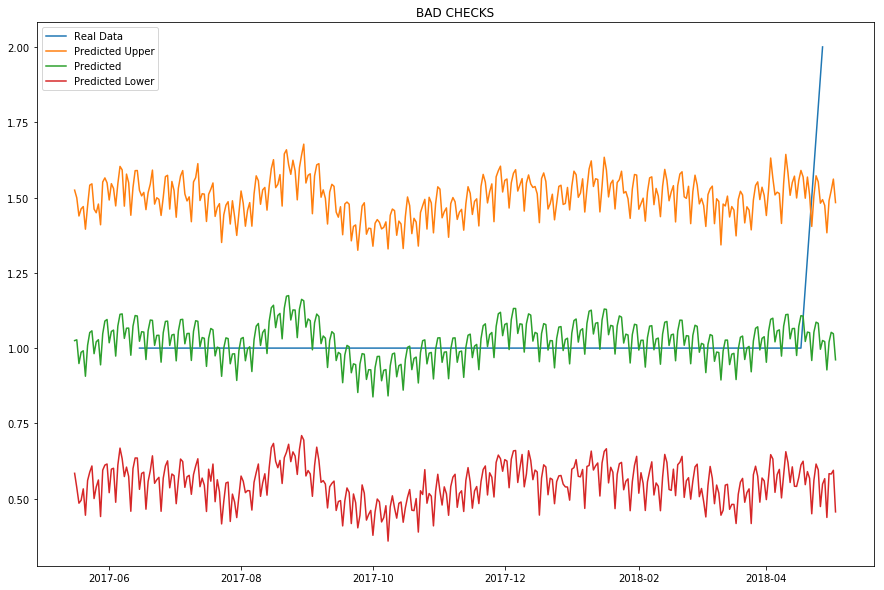

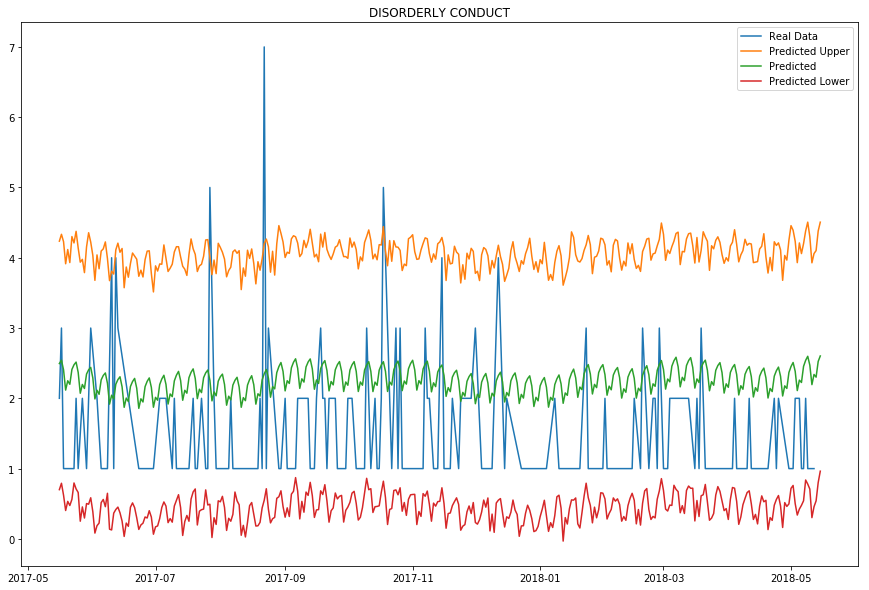

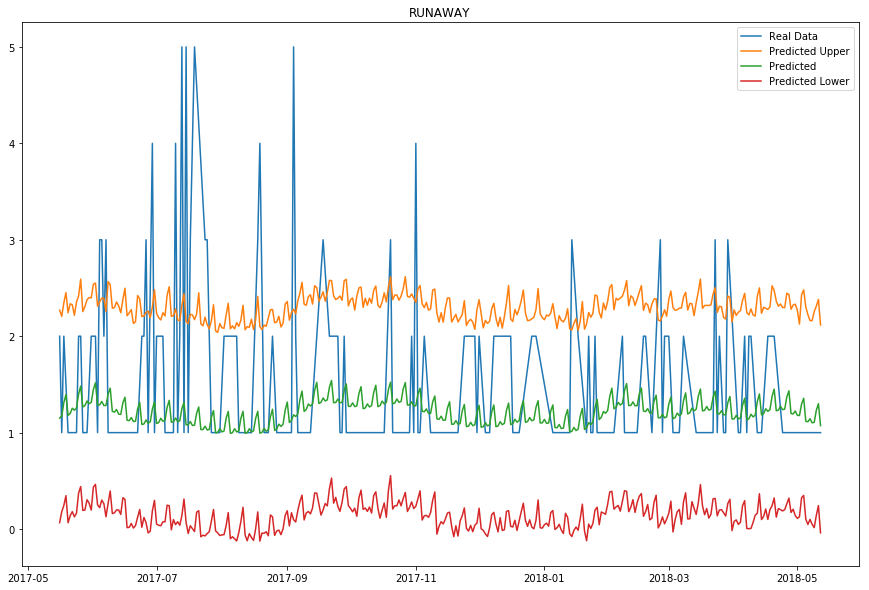

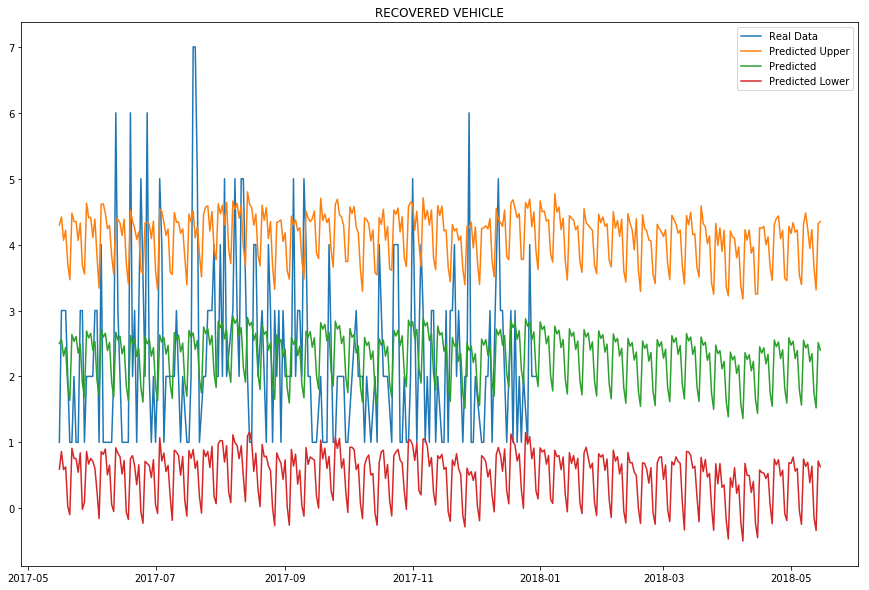

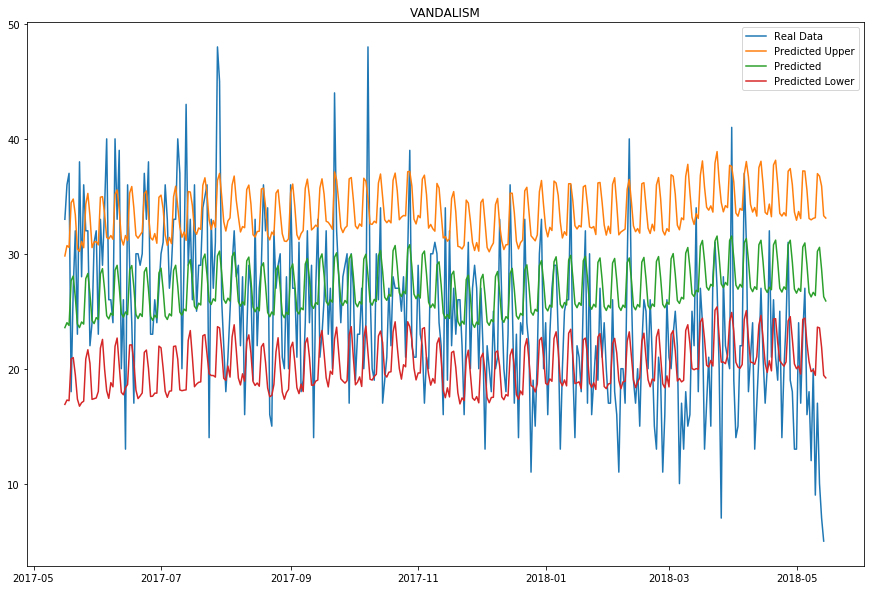

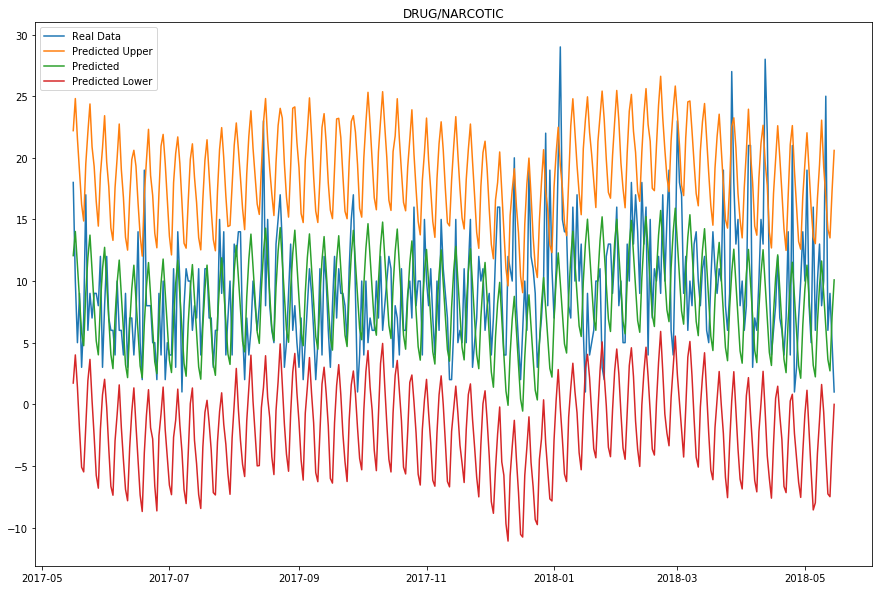

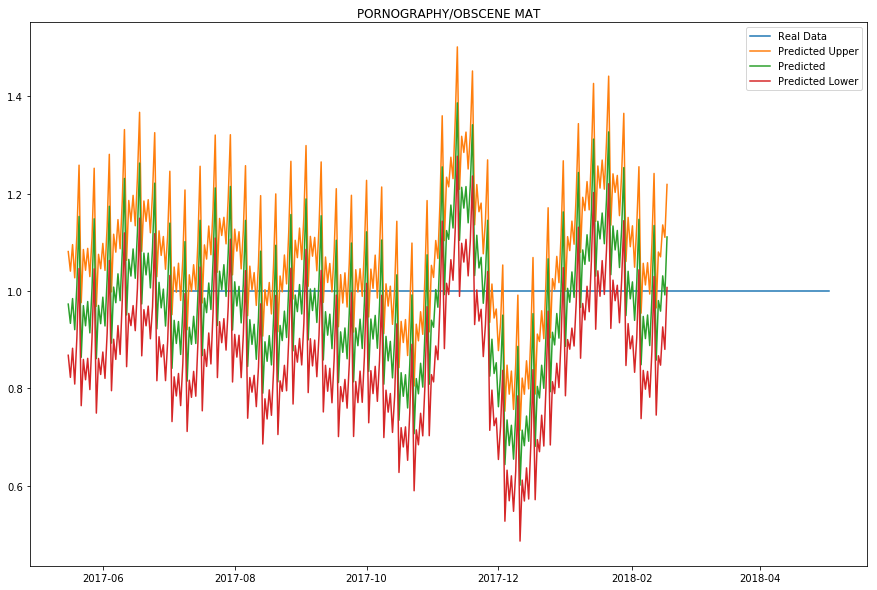

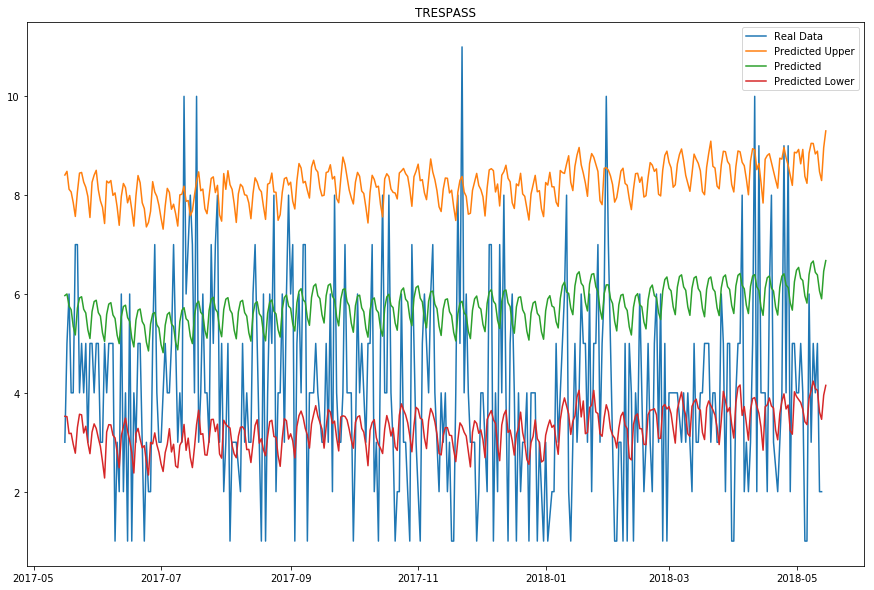

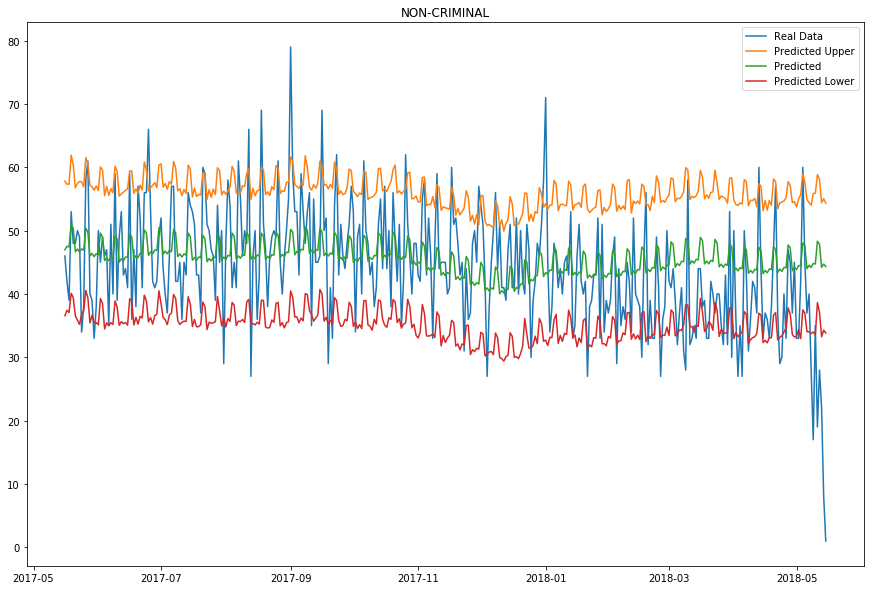

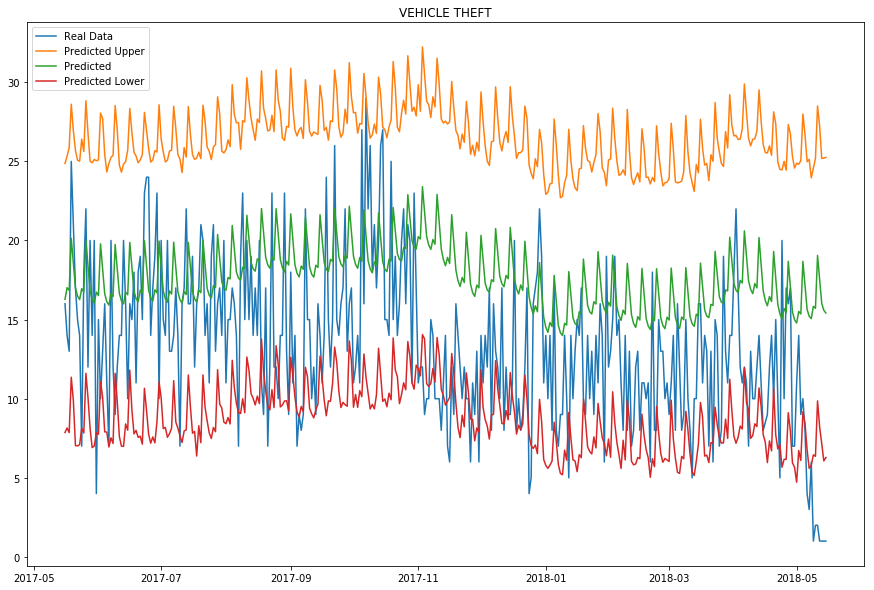

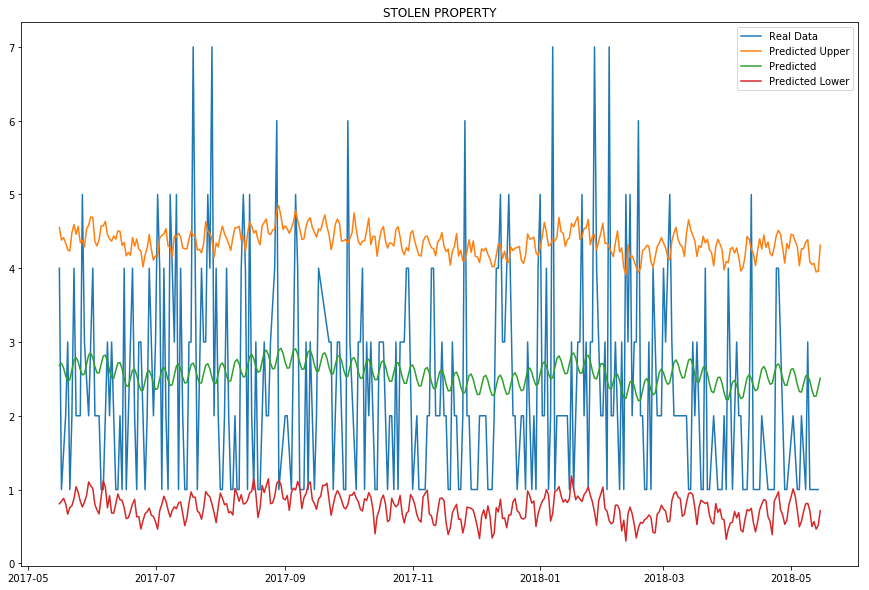

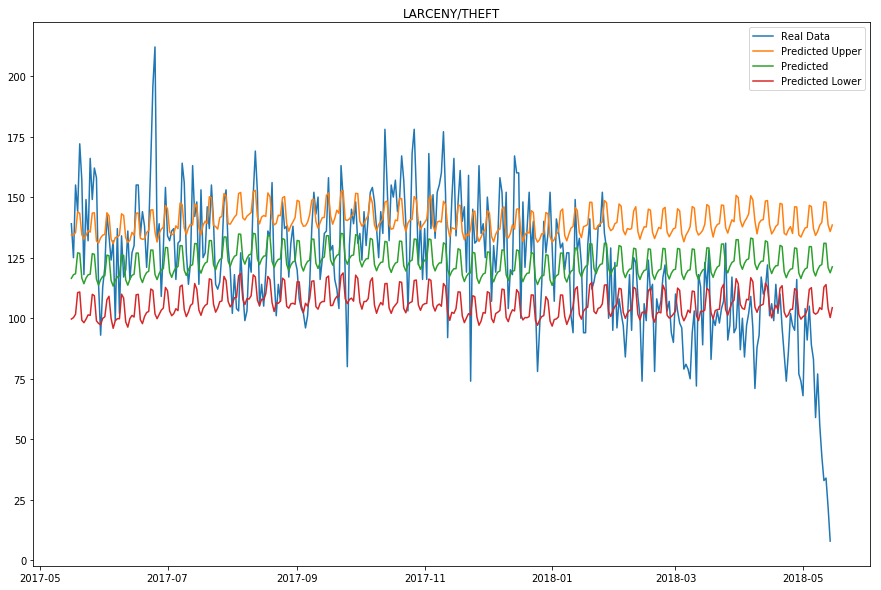

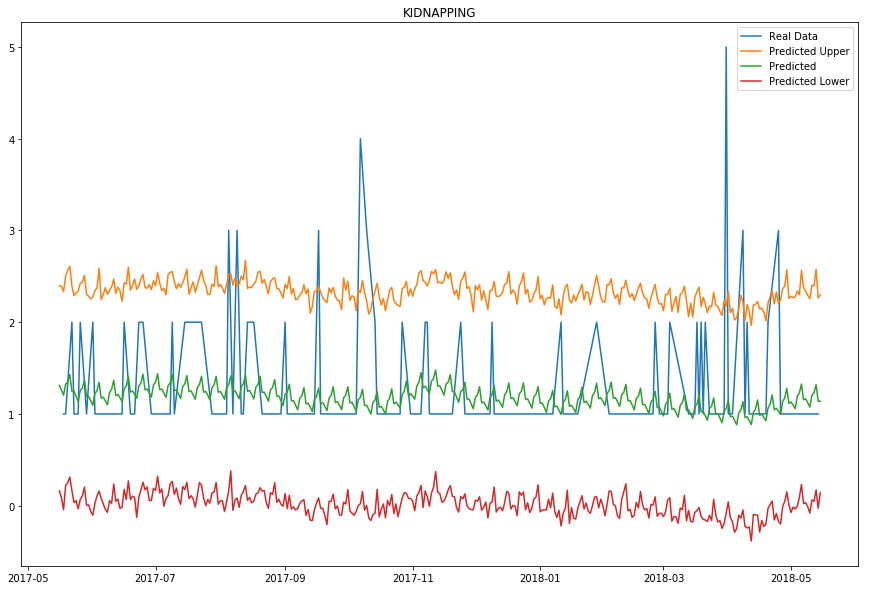

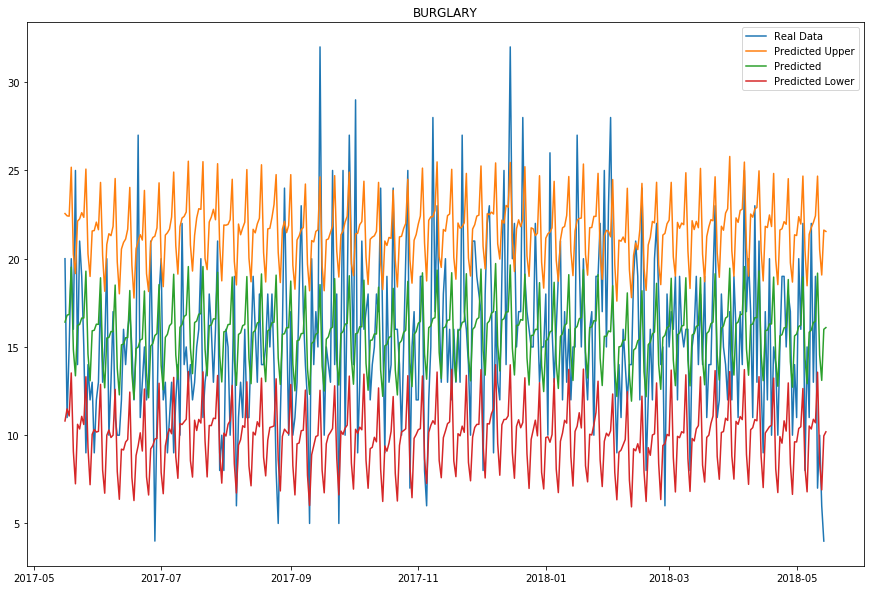

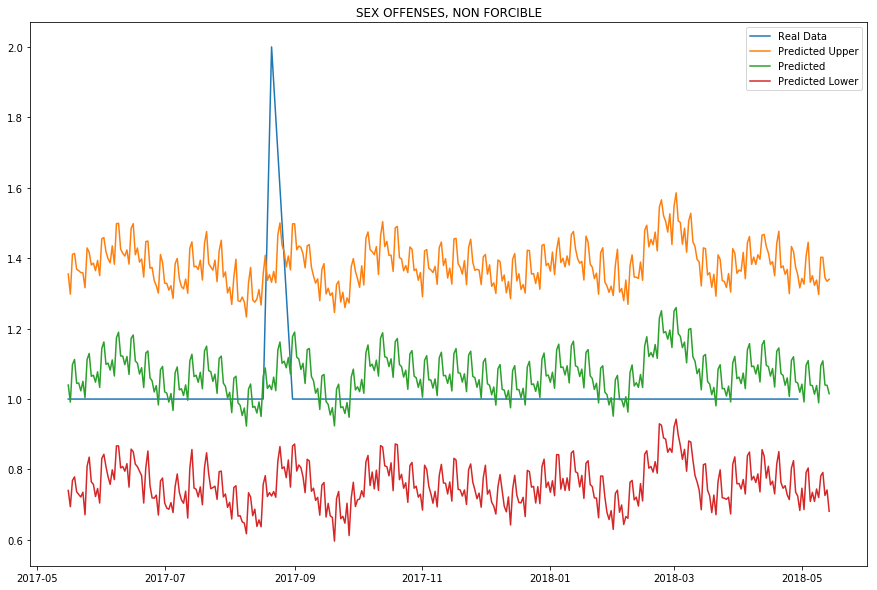

In [22]:
for cat in list_of_cats:

    data = (crime_date_count_sample
            .where(crime_date_count_sample.Category == cat)
            .withColumnRenamed('Date', 'ds')
            .withColumnRenamed('Count', 'y')
            .select('ds', 'y')
            .orderBy('ds').toPandas())
    
    
    model = fbprophet.Prophet();
    model.fit(data)
    
    future_df = model.make_future_dataframe(periods=365)
    forecast_df = model.predict(future_df)
    
    future_section = forecast_df.loc[(forecast_df['ds'] > datetime.datetime(2017, 5, 15, 0, 0))]    
    
    
    plt.figure(figsize=[15,10])
    plt.title(cat)
    
    plt.plot([d.Date for d in crime_date_count_sample_future.where(crime_date_count_sample_future.Category == cat).select("Date").collect()], [r.Count for r in crime_date_count_sample_future.where(crime_date_count_sample_future.Category == cat).select("Count").collect()],label="Real Data")
    
    plt.plot(future_section['ds'], future_section['yhat_upper'], label="Predicted Upper")
    plt.plot(future_section['ds'], future_section['yhat'], label="Predicted")
    plt.plot(future_section['ds'], future_section['yhat_lower'], label="Predicted Lower")
    
    plt.legend()
    plt.show()

### Prediction on Crime Counts for All Crime Categories
- The counts for different crime categories are all aggregated and prediction is made on the number of crimes occuring on a day

In [38]:
allCat_count = crimeDF_date.groupBy("Date").count().select("Date", "Count").orderBy("Date")

In [39]:
allCat_count = (allCat_count.withColumn("Count_t", udf(intCount, DoubleType())(allCat_count.Count))
                                   .drop("Count")
                                   .withColumnRenamed("Date", "ds")
                                   .withColumnRenamed("Count_t", "y")
                                   .cache())

In [40]:
allCat_count.show()

+-------------------+-----+
|                 ds|    y|
+-------------------+-----+
|2003-01-01 00:00:00|622.0|
|2003-01-02 00:00:00|411.0|
|2003-01-03 00:00:00|440.0|
|2003-01-04 00:00:00|347.0|
|2003-01-05 00:00:00|377.0|
|2003-01-06 00:00:00|400.0|
|2003-01-07 00:00:00|418.0|
|2003-01-08 00:00:00|528.0|
|2003-01-09 00:00:00|417.0|
|2003-01-10 00:00:00|399.0|
|2003-01-11 00:00:00|363.0|
|2003-01-12 00:00:00|324.0|
|2003-01-13 00:00:00|398.0|
|2003-01-14 00:00:00|406.0|
|2003-01-15 00:00:00|410.0|
|2003-01-16 00:00:00|406.0|
|2003-01-17 00:00:00|444.0|
|2003-01-18 00:00:00|352.0|
|2003-01-19 00:00:00|305.0|
|2003-01-20 00:00:00|414.0|
+-------------------+-----+
only showing top 20 rows



Split the data to one to be fitted to the model and one for testing

In [41]:
allCat_count_sample = allCat_count.where(allCat_count.ds.between(minDate, datetime.datetime(2017, 5, 15, 0, 0))).cache()
allCat_count_future = allCat_count.where(allCat_count.ds.between(datetime.datetime(2017, 5, 16, 0, 0), maxDate)).cache()

In [42]:
allCatCountPandas = allCat_count_sample.toPandas()

In [28]:
m = fbprophet.Prophet()
m.fit(allCatCountPandas)

In [43]:
future_df = m.make_future_dataframe(periods=365)
print future_df.tail()

             ds
5608 2018-05-11
5609 2018-05-12
5610 2018-05-13
5611 2018-05-14
5612 2018-05-15


In [45]:
forecast_df = m.predict(future_df)

In [46]:
forecast_df

ds       trend  trend_lower  trend_upper  yhat_lower  yhat_upper  \
0    2003-01-01  417.705151   417.705151   417.705151  354.719001  464.054083   
1    2003-01-02  417.674324   417.674324   417.674324  350.712414  447.791902   
2    2003-01-03  417.643498   417.643498   417.643498  376.912136  479.871923   
3    2003-01-04  417.612671   417.612671   417.612671  356.226195  459.372698   
4    2003-01-05  417.581845   417.581845   417.581845  325.851519  432.202156   
5    2003-01-06  417.551019   417.551019   417.551019  348.392532  453.264190   
6    2003-01-07  417.520192   417.520192   417.520192  355.951018  459.792883   
7    2003-01-08  417.489366   417.489366   417.489366  369.902710  473.166090   
8    2003-01-09  417.458539   417.458539   417.458539  363.387034  467.748243   
9    2003-01-10  417.427713   417.427713   417.427713  391.412638  489.646021   
10   2003-01-11  417.396887   417.396887   417.396887  372.724948  472.878224   
11   2003-01-12  417.366060   417.366060   417.366060  336.054826  443.189317   
12   2003-01-13  417.335234   417.335234   417.335234  355.437321  459.469326   
13   2003-01-14  417.304408   417.304408   417.304408  366.146605  468.874288   
14   2003-01-15  417.273581   417.273581   417.273581  381.650275  483.667581   
15   2003-01-16  417.242755   417.242755   417.242755  372.891363  477.280311   
16   2003-01-17  417.211928   417.211928   417.211928  399.268983  503.393646   
17   2003-01-18  417.181102   417.181102   417.181102  378.913314  484.737134   
18   2003-01-19  417.150276   417.150276   417.150276  347.268697  449.291981   
19   2003-01-20  417.119449   417.119449   417.119449  364.276296  463.093520   
20   2003-01-21  417.088623   417.088623   417.088623  372.989169  476.407019   
21   2003-01-22  417.057796   417.057796   417.057796  385.467311  486.639780   
22   2003-01-23  417.026970   417.026970   417.026970  366.963193  476.048755   
23   2003-01-24  416.996144   416.996144   416.996144  400.170168  502.293944   
24   2003-01-25  416.965317   416.965317   416.965317  374.658494  478.192042   
25   2003-01-26  416.934491   416.934491   416.934491  345.636561  450.142912   
26   2003-01-27  416.903665   416.903665   416.903665  356.925855  458.468232   
27   2003-01-28  416.872838   416.872838   416.872838  370.829100  473.658208   
28   2003-01-29  416.842012   416.842012   416.842012  383.966128  480.031702   
29   2003-01-30  416.811185   416.811185   416.811185  367.678911  468.127040   
...         ...         ...          ...          ...         ...         ...   
5583 2018-04-16  422.723281   419.453341   427.345650  360.127568  464.912637   
5584 2018-04-17  422.726670   419.442674   427.379156  369.684714  478.657130   
5585 2018-04-18  422.730060   419.432841   427.428486  384.182775  485.988364   
5586 2018-04-19  422.733449   419.423325   427.451491  375.034538  479.271844   
5587 2018-04-20  422.736838   419.412884   427.474248  397.135897  503.530475   
5588 2018-04-21  422.740228   419.401877   427.497005  375.681164  479.961831   
5589 2018-04-22  422.743617   419.398293   427.519762  345.395938  447.618465   
5590 2018-04-23  422.747007   419.383471   427.542519  364.468884  465.746336   
5591 2018-04-24  422.750396   419.373040   427.565276  371.971306  477.327559   
5592 2018-04-25  422.753786   419.362609   427.588033  383.196045  486.579274   
5593 2018-04-26  422.757175   419.352178   427.610790  369.966818  472.324406   
5594 2018-04-27  422.760565   419.341747   427.635677  398.361805  502.908006   
5595 2018-04-28  422.763954   419.331316   427.660430  376.039267  480.383112   
5596 2018-04-29  422.767344   419.320885   427.685184  346.040426  450.118944   
5597 2018-04-30  422.770733   419.310303   427.717883  360.125723  463.282345   
5598 2018-05-01  422.774122   419.297971   427.756228  367.837599  475.525970   
5599 2018-05-02  422.777512   419.285640   427.799188  383.767065  489.843976   
5600 2018-05-03  422.780901   419.270398   4

Extracting out the 1-year period prediction

In [47]:
future_section = forecast_df.loc[(forecast_df['ds'] > datetime.datetime(2017, 5, 15, 0, 0))]    

In [48]:
future_section

ds       trend  trend_lower  trend_upper  yhat_lower  yhat_upper  \
5248 2017-05-16  421.587814   421.587814   421.587814  375.091342  476.602902   
5249 2017-05-17  421.591203   421.591203   421.591203  383.309253  485.333770   
5250 2017-05-18  421.594593   421.594593   421.594593  374.434651  475.044538   
5251 2017-05-19  421.597982   421.597982   421.597982  402.904953  500.517707   
5252 2017-05-20  421.601372   421.601372   421.601372  374.572186  483.119853   
5253 2017-05-21  421.604761   421.604761   421.604761  347.351788  449.780270   
5254 2017-05-22  421.608150   421.608150   421.608150  357.912752  460.795090   
5255 2017-05-23  421.611540   421.611540   421.611540  371.308202  472.061804   
5256 2017-05-24  421.614929   421.614929   421.614929  380.061252  484.860818   
5257 2017-05-25  421.618319   421.618319   421.618319  372.741122  470.416989   
5258 2017-05-26  421.621708   421.621708   421.621708  396.719097  497.303615   
5259 2017-05-27  421.625098   421.625098   421.625098  377.456894  476.315293   
5260 2017-05-28  421.628487   421.628487   421.628487  338.479152  445.064459   
5261 2017-05-29  421.631877   421.631877   421.631877  355.352662  460.954705   
5262 2017-05-30  421.635266   421.635266   421.635266  369.638259  466.097291   
5263 2017-05-31  421.638656   421.638656   421.638656  374.166933  480.423205   
5264 2017-06-01  421.642045   421.642045   421.642045  366.388010  469.676473   
5265 2017-06-02  421.645434   421.645434   421.645434  390.410905  494.402964   
5266 2017-06-03  421.648824   421.648824   421.648824  366.176831  473.974911   
5267 2017-06-04  421.652213   421.652213   421.652213  340.322940  440.730013   
5268 2017-06-05  421.655603   421.655603   421.655603  347.672013  454.444373   
5269 2017-06-06  421.658992   421.658992   421.658992  361.397764  466.558312   
5270 2017-06-07  421.662382   421.662382   421.662382  366.871955  473.018857   
5271 2017-06-08  421.665771   421.665771   421.665771  355.364868  459.680976   
5272 2017-06-09  421.669161   421.669161   421.669161  383.711478  485.200270   
5273 2017-06-10  421.672550   421.672550   421.672550  363.700601  466.793244   
5274 2017-06-11  421.675940   421.675940   421.675940  330.586554  433.602257   
5275 2017-06-12  421.679329   421.679329   421.679329  345.536966  445.755536   
5276 2017-06-13  421.682718   421.682718   421.682718  353.769424  459.755378   
5277 2017-06-14  421.686108   421.686108   421.686108  369.823404  474.439660   
...         ...         ...          ...          ...         ...         ...   
5583 2018-04-16  422.723281   419.453341   427.345650  360.127568  464.912637   
5584 2018-04-17  422.726670   419.442674   427.379156  369.684714  478.657130   
5585 2018-04-18  422.730060   419.432841   427.428486  384.182775  485.988364   
5586 2018-04-19  422.733449   419.423325   427.451491  375.034538  479.271844   
5587 2018-04-20  422.736838   419.412884   427.474248  397.135897  503.530475   
5588 2018-04-21  422.740228   419.401877   427.497005  375.681164  479.961831   
5589 2018-04-22  422.743617   419.398293   427.519762  345.395938  447.618465   
5590 2018-04-23  422.747007   419.383471   427.542519  364.468884  465.746336   
5591 2018-04-24  422.750396   419.373040   427.565276  371.971306  477.327559   
5592 2018-04-25  422.753786   419.362609   427.588033  383.196045  486.579274   
5593 2018-04-26  422.757175   419.352178   427.610790  369.966818  472.324406   
5594 2018-04-27  422.760565   419.341747   427.635677  398.361805  502.908006   
5595 2018-04-28  422.763954   419.331316   427.660430  376.039267  480.383112   
5596 2018-04-29  422.767344   419.320885   427.685184  346.040426  450.118944   
5597 2018-04-30  422.770733   419.310303   427.717883  360.125723  463.282345   
5598 2018-05-01  422.774122   419.297971   427.756228  367.837599  475.525970   
5599 2018-05-02  422.777512   419.285640   427.799188  383.767065  489.843976   
5600 2018-05-03  422.780901   419.270398   4

### Plot of the data and prediction for (2017/5/16~2018/5/15) following the data

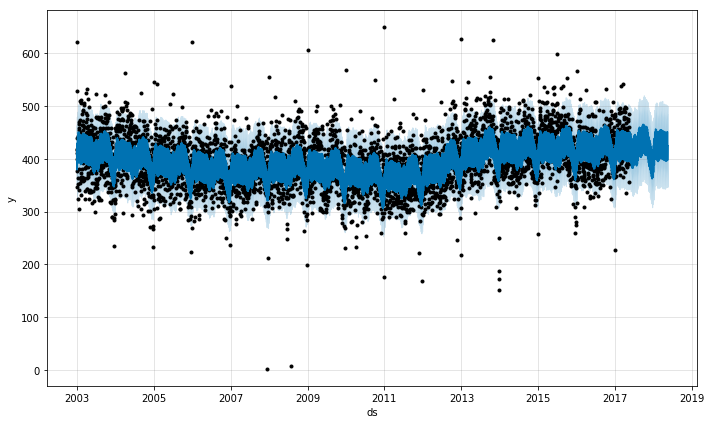

In [50]:
m.plot(forecast_df)
plt.show()

Extracting the prediction for the 1-year period between 2017/5/16 ~ 2018/5/15

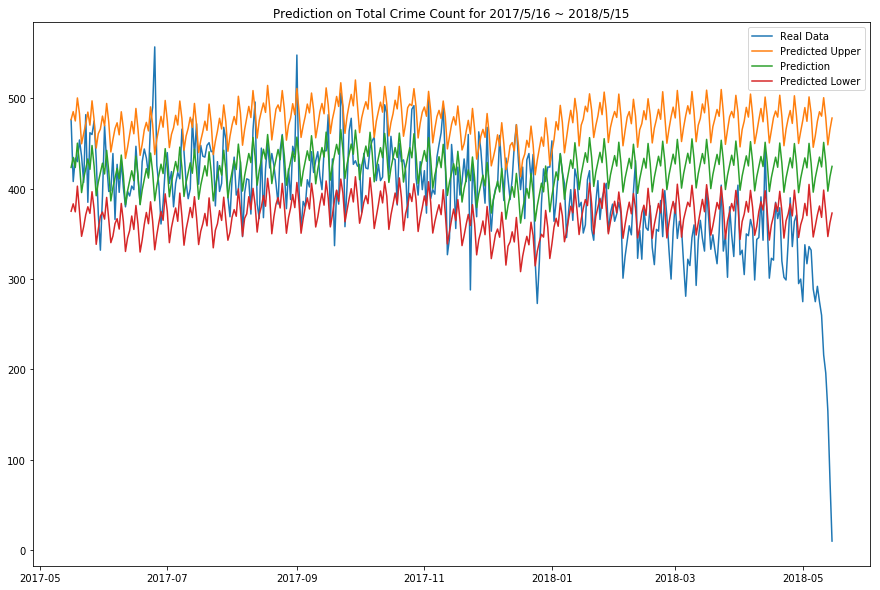

In [54]:
plt.figure(figsize=[15,10])
plt.title("Prediction on Total Crime Count for 2017/5/16 ~ 2018/5/15")
plt.plot([d.ds for d in allCat_count_future.select("ds").collect()], [r.y for r in allCat_count_future.select("y").collect()], label="Real Data")
plt.plot(future_section['ds'], future_section['yhat_upper'], label="Predicted Upper")
plt.plot(future_section['ds'], future_section['yhat'], label="Prediction")
plt.plot(future_section['ds'], future_section['yhat_lower'], label="Predicted Lower")

plt.legend()
plt.show()